# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [4]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [5]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [20]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=True)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=True)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=True) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
        w=torch.randn(w[0].shape).cuda()*1
        
        a=torch.randn(1).cuda()*0.1
        if a>0.37:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        w=self.scaleLayer(w)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        #-------------------------------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        
        if a>0.37:
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [21]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [22]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [23]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [24]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [25]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [26]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.338149, Accuracy: 10.16
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.304320, Accuracy: 11.33
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.329869, Accuracy: 10.16
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.282738, Accuracy: 10.16
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.255000, Accuracy: 11.72
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.052578, Accuracy: 17.19
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.213797, Accuracy: 16.80
Train Epoch: 0 [8960/50000 (20%)]	Loss: 1.981563, Accuracy: 22.27
Train Epoch: 0 [10240/50000 (23%)]	Loss: 1.963555, Accuracy: 18.36
Train Epoch: 0 [11520/50000 (26%)]	Loss: 2.002768, Accuracy: 21.09
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.040294, Accuracy: 15.62
Train Epoch: 0 [14080/50000 (31%)]	Loss: 1.997170, Accuracy: 17.58
Train Epoch: 0 [15360/50000 (34%)]	Loss: 2.074371, Accuracy: 19.53
Train Epoch: 0 [16640/50000 (37%)]	Loss: 2.028788, Accuracy: 19.53
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.891389, Accuracy: 23.44
Train Epoc

Train Epoch: 3 [14080/50000 (31%)]	Loss: 1.203086, Accuracy: 60.16
Train Epoch: 3 [15360/50000 (34%)]	Loss: 1.143556, Accuracy: 58.59
Train Epoch: 3 [16640/50000 (37%)]	Loss: 1.181606, Accuracy: 54.69
Train Epoch: 3 [17920/50000 (40%)]	Loss: 1.063851, Accuracy: 61.72
Train Epoch: 3 [19200/50000 (43%)]	Loss: 1.114978, Accuracy: 59.38
Train Epoch: 3 [20480/50000 (45%)]	Loss: 0.974260, Accuracy: 64.84
Train Epoch: 3 [21760/50000 (48%)]	Loss: 1.197115, Accuracy: 55.86
Train Epoch: 3 [23040/50000 (51%)]	Loss: 1.162782, Accuracy: 59.77
Train Epoch: 3 [24320/50000 (54%)]	Loss: 1.027469, Accuracy: 62.50
Train Epoch: 3 [25600/50000 (57%)]	Loss: 1.131992, Accuracy: 58.20
Train Epoch: 3 [26880/50000 (60%)]	Loss: 1.090772, Accuracy: 59.77
Train Epoch: 3 [28160/50000 (62%)]	Loss: 1.054339, Accuracy: 58.59
Train Epoch: 3 [29440/50000 (65%)]	Loss: 1.116722, Accuracy: 58.59
Train Epoch: 3 [30720/50000 (68%)]	Loss: 1.073895, Accuracy: 61.33
Train Epoch: 3 [32000/50000 (71%)]	Loss: 1.155100, Accuracy: 6

Train Epoch: 6 [26880/50000 (60%)]	Loss: 0.815681, Accuracy: 72.66
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.709232, Accuracy: 74.22
Train Epoch: 6 [29440/50000 (65%)]	Loss: 0.868759, Accuracy: 70.70
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.795610, Accuracy: 75.78
Train Epoch: 6 [32000/50000 (71%)]	Loss: 0.809888, Accuracy: 70.31
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.755065, Accuracy: 72.66
Train Epoch: 6 [34560/50000 (77%)]	Loss: 0.694649, Accuracy: 73.44
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.761161, Accuracy: 77.34
Train Epoch: 6 [37120/50000 (82%)]	Loss: 0.810432, Accuracy: 72.66
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.634090, Accuracy: 78.91
Train Epoch: 6 [39680/50000 (88%)]	Loss: 0.856870, Accuracy: 69.92
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.717498, Accuracy: 75.78
Train Epoch: 6 [42240/50000 (94%)]	Loss: 0.804358, Accuracy: 71.09
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.742179, Accuracy: 74.22
Train Epoch: 6 [35000/50000 (99%)]	Loss: 0.777682, Accuracy: 7

Train Epoch: 7 [38400/50000 (85%)]	Loss: 0.639484, Accuracy: 77.34
Train Epoch: 7 [39680/50000 (88%)]	Loss: 0.699970, Accuracy: 76.56
Train Epoch: 7 [40960/50000 (91%)]	Loss: 0.659535, Accuracy: 77.34
Train Epoch: 7 [42240/50000 (94%)]	Loss: 0.759625, Accuracy: 75.00
Train Epoch: 7 [43520/50000 (97%)]	Loss: 0.670575, Accuracy: 76.17
Train Epoch: 7 [35000/50000 (99%)]	Loss: 0.605544, Accuracy: 81.00

Validation set: Average loss: 0.7942, Accuracy: 3643/5000 (72.00%)

the time of this epoch:[37.28758764266968 s]
Train Epoch: 8 [0/50000 (0%)]	Loss: 0.712329, Accuracy: 76.56
Train Epoch: 8 [1280/50000 (3%)]	Loss: 0.632701, Accuracy: 77.34
Train Epoch: 8 [2560/50000 (6%)]	Loss: 0.610945, Accuracy: 78.91
Train Epoch: 8 [3840/50000 (9%)]	Loss: 0.641490, Accuracy: 80.08
Train Epoch: 8 [5120/50000 (11%)]	Loss: 0.681157, Accuracy: 75.39
Train Epoch: 8 [6400/50000 (14%)]	Loss: 0.620435, Accuracy: 78.91
Train Epoch: 8 [7680/50000 (17%)]	Loss: 0.687198, Accuracy: 76.95
Train Epoch: 8 [8960/50000 (2

Train Epoch: 8 [16640/50000 (37%)]	Loss: 0.731598, Accuracy: 75.00
Train Epoch: 8 [17920/50000 (40%)]	Loss: 0.742448, Accuracy: 73.83
Train Epoch: 8 [19200/50000 (43%)]	Loss: 0.601861, Accuracy: 78.91
Train Epoch: 8 [20480/50000 (45%)]	Loss: 0.608511, Accuracy: 80.08
Train Epoch: 8 [21760/50000 (48%)]	Loss: 0.632084, Accuracy: 79.30
Train Epoch: 8 [23040/50000 (51%)]	Loss: 0.693853, Accuracy: 76.56
Train Epoch: 8 [24320/50000 (54%)]	Loss: 0.642934, Accuracy: 77.73
Train Epoch: 8 [25600/50000 (57%)]	Loss: 0.663163, Accuracy: 78.12
Train Epoch: 8 [26880/50000 (60%)]	Loss: 0.575004, Accuracy: 80.08
Train Epoch: 8 [28160/50000 (62%)]	Loss: 0.638818, Accuracy: 78.12
Train Epoch: 8 [29440/50000 (65%)]	Loss: 0.708384, Accuracy: 76.17
Train Epoch: 8 [30720/50000 (68%)]	Loss: 0.592038, Accuracy: 76.56
Train Epoch: 8 [32000/50000 (71%)]	Loss: 0.676872, Accuracy: 77.73
Train Epoch: 8 [33280/50000 (74%)]	Loss: 0.601220, Accuracy: 78.12
Train Epoch: 8 [34560/50000 (77%)]	Loss: 0.520000, Accuracy: 8

Train Epoch: 11 [28160/50000 (62%)]	Loss: 0.483703, Accuracy: 84.38
Train Epoch: 11 [29440/50000 (65%)]	Loss: 0.452407, Accuracy: 84.38
Train Epoch: 11 [30720/50000 (68%)]	Loss: 0.527640, Accuracy: 80.08
Train Epoch: 11 [32000/50000 (71%)]	Loss: 0.683207, Accuracy: 76.17
Train Epoch: 11 [33280/50000 (74%)]	Loss: 0.638856, Accuracy: 78.52
Train Epoch: 11 [34560/50000 (77%)]	Loss: 0.675265, Accuracy: 77.73
Train Epoch: 11 [35840/50000 (80%)]	Loss: 0.479366, Accuracy: 85.16
Train Epoch: 11 [37120/50000 (82%)]	Loss: 0.499024, Accuracy: 85.16
Train Epoch: 11 [38400/50000 (85%)]	Loss: 0.671398, Accuracy: 78.91
Train Epoch: 11 [39680/50000 (88%)]	Loss: 0.504102, Accuracy: 82.03
Train Epoch: 11 [40960/50000 (91%)]	Loss: 0.626708, Accuracy: 79.69
Train Epoch: 11 [42240/50000 (94%)]	Loss: 0.488861, Accuracy: 83.20
Train Epoch: 11 [43520/50000 (97%)]	Loss: 0.468985, Accuracy: 85.55
Train Epoch: 11 [35000/50000 (99%)]	Loss: 0.511548, Accuracy: 83.50

Validation set: Average loss: 0.7689, Accuracy:

Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.464960, Accuracy: 84.38
Train Epoch: 13 [3840/50000 (9%)]	Loss: 0.429494, Accuracy: 85.16
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.591854, Accuracy: 78.91
Train Epoch: 13 [6400/50000 (14%)]	Loss: 0.568055, Accuracy: 80.47
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.576136, Accuracy: 81.25
Train Epoch: 13 [8960/50000 (20%)]	Loss: 0.459139, Accuracy: 81.64
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.483217, Accuracy: 83.59
Train Epoch: 13 [11520/50000 (26%)]	Loss: 0.516467, Accuracy: 81.64
Train Epoch: 13 [12800/50000 (28%)]	Loss: 0.438978, Accuracy: 85.94
Train Epoch: 13 [14080/50000 (31%)]	Loss: 0.542343, Accuracy: 80.86
Train Epoch: 13 [15360/50000 (34%)]	Loss: 0.446411, Accuracy: 84.77
Train Epoch: 13 [16640/50000 (37%)]	Loss: 0.514256, Accuracy: 80.47
Train Epoch: 13 [17920/50000 (40%)]	Loss: 0.612899, Accuracy: 80.47
Train Epoch: 13 [19200/50000 (43%)]	Loss: 0.553688, Accuracy: 77.73
Train Epoch: 13 [20480/50000 (45%)]	Loss: 0.451644, Accu

Train Epoch: 16 [12800/50000 (28%)]	Loss: 0.460187, Accuracy: 84.77
Train Epoch: 16 [14080/50000 (31%)]	Loss: 0.583097, Accuracy: 80.08
Train Epoch: 16 [15360/50000 (34%)]	Loss: 0.573029, Accuracy: 78.91
Train Epoch: 16 [16640/50000 (37%)]	Loss: 0.504418, Accuracy: 82.42
Train Epoch: 16 [17920/50000 (40%)]	Loss: 0.535916, Accuracy: 82.03
Train Epoch: 16 [19200/50000 (43%)]	Loss: 0.554714, Accuracy: 81.64
Train Epoch: 16 [20480/50000 (45%)]	Loss: 0.464161, Accuracy: 83.20
Train Epoch: 16 [21760/50000 (48%)]	Loss: 0.477921, Accuracy: 82.42
Train Epoch: 16 [23040/50000 (51%)]	Loss: 0.571569, Accuracy: 80.86
Train Epoch: 16 [24320/50000 (54%)]	Loss: 0.475526, Accuracy: 80.47
Train Epoch: 16 [25600/50000 (57%)]	Loss: 0.545722, Accuracy: 79.30
Train Epoch: 16 [26880/50000 (60%)]	Loss: 0.390548, Accuracy: 85.55
Train Epoch: 16 [28160/50000 (62%)]	Loss: 0.469203, Accuracy: 83.59
Train Epoch: 16 [29440/50000 (65%)]	Loss: 0.489260, Accuracy: 83.59
Train Epoch: 16 [30720/50000 (68%)]	Loss: 0.4734

Train Epoch: 19 [21760/50000 (48%)]	Loss: 0.428284, Accuracy: 89.06
Train Epoch: 19 [23040/50000 (51%)]	Loss: 0.404333, Accuracy: 85.94
Train Epoch: 19 [24320/50000 (54%)]	Loss: 0.451606, Accuracy: 87.89
Train Epoch: 19 [25600/50000 (57%)]	Loss: 0.437902, Accuracy: 83.59
Train Epoch: 19 [26880/50000 (60%)]	Loss: 0.455468, Accuracy: 85.94
Train Epoch: 19 [28160/50000 (62%)]	Loss: 0.392357, Accuracy: 85.94
Train Epoch: 19 [29440/50000 (65%)]	Loss: 0.509752, Accuracy: 82.42
Train Epoch: 19 [30720/50000 (68%)]	Loss: 0.457309, Accuracy: 83.98
Train Epoch: 19 [32000/50000 (71%)]	Loss: 0.426720, Accuracy: 84.38
Train Epoch: 19 [33280/50000 (74%)]	Loss: 0.405054, Accuracy: 85.94
Train Epoch: 19 [34560/50000 (77%)]	Loss: 0.472803, Accuracy: 84.38
Train Epoch: 19 [35840/50000 (80%)]	Loss: 0.529416, Accuracy: 84.38
Train Epoch: 19 [37120/50000 (82%)]	Loss: 0.507297, Accuracy: 81.64
Train Epoch: 19 [38400/50000 (85%)]	Loss: 0.547641, Accuracy: 80.86
Train Epoch: 19 [39680/50000 (88%)]	Loss: 0.4988

Train Epoch: 22 [32000/50000 (71%)]	Loss: 0.434194, Accuracy: 83.20
Train Epoch: 22 [33280/50000 (74%)]	Loss: 0.420321, Accuracy: 84.77
Train Epoch: 22 [34560/50000 (77%)]	Loss: 0.461061, Accuracy: 83.20
Train Epoch: 22 [35840/50000 (80%)]	Loss: 0.583857, Accuracy: 83.20
Train Epoch: 22 [37120/50000 (82%)]	Loss: 0.471321, Accuracy: 84.77
Train Epoch: 22 [38400/50000 (85%)]	Loss: 0.447118, Accuracy: 85.16
Train Epoch: 22 [39680/50000 (88%)]	Loss: 0.493942, Accuracy: 83.59
Train Epoch: 22 [40960/50000 (91%)]	Loss: 0.465324, Accuracy: 82.42
Train Epoch: 22 [42240/50000 (94%)]	Loss: 0.410767, Accuracy: 84.77
Train Epoch: 22 [43520/50000 (97%)]	Loss: 0.463748, Accuracy: 85.94
Train Epoch: 22 [35000/50000 (99%)]	Loss: 0.443966, Accuracy: 82.00

Validation set: Average loss: 0.6557, Accuracy: 3926/5000 (78.00%)

the time of this epoch:[37.13746905326843 s]

Test set: Average loss: 0.6738, Accuracy: 7814/10000 (78.14%)

Train Epoch: 23 [0/50000 (0%)]	Loss: 0.317176, Accuracy: 89.84
Train Epoch

Train Epoch: 25 [40960/50000 (91%)]	Loss: 0.319868, Accuracy: 88.28
Train Epoch: 25 [42240/50000 (94%)]	Loss: 0.538152, Accuracy: 81.25
Train Epoch: 25 [43520/50000 (97%)]	Loss: 0.431350, Accuracy: 84.38
Train Epoch: 25 [35000/50000 (99%)]	Loss: 0.496195, Accuracy: 84.50

Validation set: Average loss: 0.4915, Accuracy: 4167/5000 (83.00%)

the time of this epoch:[40.372382164001465 s]
Train Epoch: 26 [0/50000 (0%)]	Loss: 0.367787, Accuracy: 87.11
Train Epoch: 26 [1280/50000 (3%)]	Loss: 0.353344, Accuracy: 88.67
Train Epoch: 26 [2560/50000 (6%)]	Loss: 0.453647, Accuracy: 83.98
Train Epoch: 26 [3840/50000 (9%)]	Loss: 0.389394, Accuracy: 88.67
Train Epoch: 26 [5120/50000 (11%)]	Loss: 0.364315, Accuracy: 87.89
Train Epoch: 26 [6400/50000 (14%)]	Loss: 0.387312, Accuracy: 87.89
Train Epoch: 26 [7680/50000 (17%)]	Loss: 0.321927, Accuracy: 88.67
Train Epoch: 26 [8960/50000 (20%)]	Loss: 0.530935, Accuracy: 84.77
Train Epoch: 26 [10240/50000 (23%)]	Loss: 0.347840, Accuracy: 88.67
Train Epoch: 26 

Train Epoch: 29 [1280/50000 (3%)]	Loss: 0.395485, Accuracy: 87.89
Train Epoch: 29 [2560/50000 (6%)]	Loss: 0.373348, Accuracy: 87.50
Train Epoch: 29 [3840/50000 (9%)]	Loss: 0.382834, Accuracy: 87.50
Train Epoch: 29 [5120/50000 (11%)]	Loss: 0.386995, Accuracy: 87.50
Train Epoch: 29 [6400/50000 (14%)]	Loss: 0.346553, Accuracy: 90.23
Train Epoch: 29 [7680/50000 (17%)]	Loss: 0.330155, Accuracy: 87.50
Train Epoch: 29 [8960/50000 (20%)]	Loss: 0.481647, Accuracy: 84.38
Train Epoch: 29 [10240/50000 (23%)]	Loss: 0.413256, Accuracy: 85.55
Train Epoch: 29 [11520/50000 (26%)]	Loss: 0.352385, Accuracy: 87.89
Train Epoch: 29 [12800/50000 (28%)]	Loss: 0.426055, Accuracy: 85.55
Train Epoch: 29 [14080/50000 (31%)]	Loss: 0.419441, Accuracy: 85.94
Train Epoch: 29 [15360/50000 (34%)]	Loss: 0.333816, Accuracy: 87.89
Train Epoch: 29 [16640/50000 (37%)]	Loss: 0.474279, Accuracy: 85.55
Train Epoch: 29 [17920/50000 (40%)]	Loss: 0.377791, Accuracy: 86.33
Train Epoch: 29 [19200/50000 (43%)]	Loss: 0.386376, Accura

Train Epoch: 29 [23040/50000 (51%)]	Loss: 0.500510, Accuracy: 83.20
Train Epoch: 29 [24320/50000 (54%)]	Loss: 0.490648, Accuracy: 83.59
Train Epoch: 29 [25600/50000 (57%)]	Loss: 0.386502, Accuracy: 84.38
Train Epoch: 29 [26880/50000 (60%)]	Loss: 0.344859, Accuracy: 87.11
Train Epoch: 29 [28160/50000 (62%)]	Loss: 0.394168, Accuracy: 85.55
Train Epoch: 29 [29440/50000 (65%)]	Loss: 0.358278, Accuracy: 87.11
Train Epoch: 29 [30720/50000 (68%)]	Loss: 0.395880, Accuracy: 86.33
Train Epoch: 29 [32000/50000 (71%)]	Loss: 0.444139, Accuracy: 83.98
Train Epoch: 29 [33280/50000 (74%)]	Loss: 0.484821, Accuracy: 83.20
Train Epoch: 29 [34560/50000 (77%)]	Loss: 0.425060, Accuracy: 83.59
Train Epoch: 29 [35840/50000 (80%)]	Loss: 0.370270, Accuracy: 88.28
Train Epoch: 29 [37120/50000 (82%)]	Loss: 0.457215, Accuracy: 85.94
Train Epoch: 29 [38400/50000 (85%)]	Loss: 0.450193, Accuracy: 85.55
Train Epoch: 29 [39680/50000 (88%)]	Loss: 0.464251, Accuracy: 85.16
Train Epoch: 29 [40960/50000 (91%)]	Loss: 0.4866

Train Epoch: 32 [33280/50000 (74%)]	Loss: 0.476465, Accuracy: 81.25
Train Epoch: 32 [34560/50000 (77%)]	Loss: 0.595142, Accuracy: 81.25
Train Epoch: 32 [35840/50000 (80%)]	Loss: 0.441451, Accuracy: 82.42
Train Epoch: 32 [37120/50000 (82%)]	Loss: 0.399912, Accuracy: 86.72
Train Epoch: 32 [38400/50000 (85%)]	Loss: 0.471911, Accuracy: 85.16
torch.Size([512, 1, 1])
tensor([[[ 2.1827]],

        [[ 2.7861]],

        [[ 1.4832]],

        [[ 0.7620]],

        [[-0.2586]],

        [[-3.1110]],

        [[-1.0834]],

        [[ 0.0202]],

        [[-0.9021]],

        [[-0.1792]],

        [[ 0.2062]],

        [[-0.4611]],

        [[ 0.9997]],

        [[-0.3031]],

        [[-0.3460]],

        [[ 2.2126]],

        [[ 0.0883]],

        [[-0.5323]],

        [[-1.5050]],

        [[ 0.9350]],

        [[ 1.8059]],

        [[ 0.5323]],

        [[-0.0633]],

        [[ 1.5515]],

        [[-1.0501]],

        [[ 0.2856]],

        [[-1.1923]],

        [[ 0.6546]],

        [[-1.1779]],

Train Epoch: 32 [39680/50000 (88%)]	Loss: 0.448632, Accuracy: 84.77
Train Epoch: 32 [40960/50000 (91%)]	Loss: 0.340177, Accuracy: 88.67
Train Epoch: 32 [42240/50000 (94%)]	Loss: 0.397518, Accuracy: 87.89
Train Epoch: 32 [43520/50000 (97%)]	Loss: 0.335469, Accuracy: 88.28
Train Epoch: 32 [35000/50000 (99%)]	Loss: 0.468708, Accuracy: 83.00

Validation set: Average loss: 0.5910, Accuracy: 4024/5000 (80.00%)

the time of this epoch:[37.19319534301758 s]

Test set: Average loss: 0.6183, Accuracy: 8001/10000 (80.01%)

Train Epoch: 33 [0/50000 (0%)]	Loss: 0.370881, Accuracy: 88.28
Train Epoch: 33 [1280/50000 (3%)]	Loss: 0.373290, Accuracy: 88.28
Train Epoch: 33 [2560/50000 (6%)]	Loss: 0.324249, Accuracy: 89.06
Train Epoch: 33 [3840/50000 (9%)]	Loss: 0.360705, Accuracy: 87.11
Train Epoch: 33 [5120/50000 (11%)]	Loss: 0.325582, Accuracy: 87.50
Train Epoch: 33 [6400/50000 (14%)]	Loss: 0.434640, Accuracy: 85.16
Train Epoch: 33 [7680/50000 (17%)]	Loss: 0.407250, Accuracy: 86.33
Train Epoch: 33 [896

Train Epoch: 36 [0/50000 (0%)]	Loss: 0.276476, Accuracy: 89.45
Train Epoch: 36 [1280/50000 (3%)]	Loss: 0.334167, Accuracy: 87.11
Train Epoch: 36 [2560/50000 (6%)]	Loss: 0.370291, Accuracy: 87.50
Train Epoch: 36 [3840/50000 (9%)]	Loss: 0.368346, Accuracy: 88.28
Train Epoch: 36 [5120/50000 (11%)]	Loss: 0.345761, Accuracy: 89.06
Train Epoch: 36 [6400/50000 (14%)]	Loss: 0.354239, Accuracy: 87.89
Train Epoch: 36 [7680/50000 (17%)]	Loss: 0.405993, Accuracy: 86.72
Train Epoch: 36 [8960/50000 (20%)]	Loss: 0.392136, Accuracy: 85.16
Train Epoch: 36 [10240/50000 (23%)]	Loss: 0.328817, Accuracy: 89.45
Train Epoch: 36 [11520/50000 (26%)]	Loss: 0.450436, Accuracy: 85.94
Train Epoch: 36 [12800/50000 (28%)]	Loss: 0.311968, Accuracy: 89.45
Train Epoch: 36 [14080/50000 (31%)]	Loss: 0.422932, Accuracy: 83.59
Train Epoch: 36 [15360/50000 (34%)]	Loss: 0.524884, Accuracy: 80.86
Train Epoch: 36 [16640/50000 (37%)]	Loss: 0.398961, Accuracy: 86.33
Train Epoch: 36 [17920/50000 (40%)]	Loss: 0.519006, Accuracy: 8

Train Epoch: 39 [8960/50000 (20%)]	Loss: 0.396526, Accuracy: 86.72
Train Epoch: 39 [10240/50000 (23%)]	Loss: 0.371036, Accuracy: 84.38
Train Epoch: 39 [11520/50000 (26%)]	Loss: 0.323127, Accuracy: 89.06
Train Epoch: 39 [12800/50000 (28%)]	Loss: 0.340309, Accuracy: 87.11
Train Epoch: 39 [14080/50000 (31%)]	Loss: 0.371862, Accuracy: 87.11
Train Epoch: 39 [15360/50000 (34%)]	Loss: 0.456115, Accuracy: 86.33
Train Epoch: 39 [16640/50000 (37%)]	Loss: 0.328187, Accuracy: 87.89
Train Epoch: 39 [17920/50000 (40%)]	Loss: 0.374574, Accuracy: 88.28
Train Epoch: 39 [19200/50000 (43%)]	Loss: 0.297548, Accuracy: 90.62
Train Epoch: 39 [20480/50000 (45%)]	Loss: 0.290296, Accuracy: 91.02
Train Epoch: 39 [21760/50000 (48%)]	Loss: 0.401279, Accuracy: 85.94
Train Epoch: 39 [23040/50000 (51%)]	Loss: 0.561474, Accuracy: 80.47
Train Epoch: 39 [24320/50000 (54%)]	Loss: 0.339927, Accuracy: 85.94
Train Epoch: 39 [25600/50000 (57%)]	Loss: 0.270487, Accuracy: 89.84
Train Epoch: 39 [26880/50000 (60%)]	Loss: 0.44314

Train Epoch: 41 [3840/50000 (9%)]	Loss: 0.410751, Accuracy: 85.94
Train Epoch: 41 [5120/50000 (11%)]	Loss: 0.488346, Accuracy: 82.03
Train Epoch: 41 [6400/50000 (14%)]	Loss: 0.317977, Accuracy: 89.06
Train Epoch: 41 [7680/50000 (17%)]	Loss: 0.368295, Accuracy: 88.28
Train Epoch: 41 [8960/50000 (20%)]	Loss: 0.388625, Accuracy: 87.11
Train Epoch: 41 [10240/50000 (23%)]	Loss: 0.307511, Accuracy: 87.89
Train Epoch: 41 [11520/50000 (26%)]	Loss: 0.399497, Accuracy: 85.94
Train Epoch: 41 [12800/50000 (28%)]	Loss: 0.449929, Accuracy: 85.16
Train Epoch: 41 [14080/50000 (31%)]	Loss: 0.333339, Accuracy: 88.67
Train Epoch: 41 [15360/50000 (34%)]	Loss: 0.422523, Accuracy: 87.11
Train Epoch: 41 [16640/50000 (37%)]	Loss: 0.331731, Accuracy: 89.06
Train Epoch: 41 [17920/50000 (40%)]	Loss: 0.281993, Accuracy: 91.41
Train Epoch: 41 [19200/50000 (43%)]	Loss: 0.403721, Accuracy: 86.33
Train Epoch: 41 [20480/50000 (45%)]	Loss: 0.430023, Accuracy: 85.16
Train Epoch: 41 [21760/50000 (48%)]	Loss: 0.419578, Ac

Train Epoch: 44 [14080/50000 (31%)]	Loss: 0.353893, Accuracy: 87.50
Train Epoch: 44 [15360/50000 (34%)]	Loss: 0.306179, Accuracy: 91.02
Train Epoch: 44 [16640/50000 (37%)]	Loss: 0.339046, Accuracy: 89.84
Train Epoch: 44 [17920/50000 (40%)]	Loss: 0.342892, Accuracy: 88.28
Train Epoch: 44 [19200/50000 (43%)]	Loss: 0.489038, Accuracy: 84.77
Train Epoch: 44 [20480/50000 (45%)]	Loss: 0.450292, Accuracy: 81.64
Train Epoch: 44 [21760/50000 (48%)]	Loss: 0.438449, Accuracy: 85.94
Train Epoch: 44 [23040/50000 (51%)]	Loss: 0.400312, Accuracy: 85.55
Train Epoch: 44 [24320/50000 (54%)]	Loss: 0.355004, Accuracy: 87.11
Train Epoch: 44 [25600/50000 (57%)]	Loss: 0.570280, Accuracy: 81.64
Train Epoch: 44 [26880/50000 (60%)]	Loss: 0.504962, Accuracy: 83.98
Train Epoch: 44 [28160/50000 (62%)]	Loss: 0.418775, Accuracy: 85.16
Train Epoch: 44 [29440/50000 (65%)]	Loss: 0.439724, Accuracy: 84.77
Train Epoch: 44 [30720/50000 (68%)]	Loss: 0.451019, Accuracy: 83.98
Train Epoch: 44 [32000/50000 (71%)]	Loss: 0.3556

Train Epoch: 47 [23040/50000 (51%)]	Loss: 0.423258, Accuracy: 86.33
Train Epoch: 47 [24320/50000 (54%)]	Loss: 0.332468, Accuracy: 87.11
Train Epoch: 47 [25600/50000 (57%)]	Loss: 0.410791, Accuracy: 85.55
Train Epoch: 47 [26880/50000 (60%)]	Loss: 0.357101, Accuracy: 87.11
Train Epoch: 47 [28160/50000 (62%)]	Loss: 0.274278, Accuracy: 91.02
Train Epoch: 47 [29440/50000 (65%)]	Loss: 0.594126, Accuracy: 79.30
Train Epoch: 47 [30720/50000 (68%)]	Loss: 0.375678, Accuracy: 87.50
Train Epoch: 47 [32000/50000 (71%)]	Loss: 0.403489, Accuracy: 86.72
Train Epoch: 47 [33280/50000 (74%)]	Loss: 0.451478, Accuracy: 85.94
Train Epoch: 47 [34560/50000 (77%)]	Loss: 0.289667, Accuracy: 89.06
Train Epoch: 47 [35840/50000 (80%)]	Loss: 0.367403, Accuracy: 87.89
Train Epoch: 47 [37120/50000 (82%)]	Loss: 0.374547, Accuracy: 86.33
Train Epoch: 47 [38400/50000 (85%)]	Loss: 0.425875, Accuracy: 87.11
Train Epoch: 47 [39680/50000 (88%)]	Loss: 0.427326, Accuracy: 86.72
Train Epoch: 47 [40960/50000 (91%)]	Loss: 0.3929

Train Epoch: 50 [33280/50000 (74%)]	Loss: 0.428095, Accuracy: 84.77
Train Epoch: 50 [34560/50000 (77%)]	Loss: 0.412860, Accuracy: 84.77
Train Epoch: 50 [35840/50000 (80%)]	Loss: 0.358990, Accuracy: 86.72
Train Epoch: 50 [37120/50000 (82%)]	Loss: 0.290486, Accuracy: 91.80
Train Epoch: 50 [38400/50000 (85%)]	Loss: 0.413999, Accuracy: 85.16
Train Epoch: 50 [39680/50000 (88%)]	Loss: 0.255755, Accuracy: 92.19
Train Epoch: 50 [40960/50000 (91%)]	Loss: 0.384433, Accuracy: 85.55
Train Epoch: 50 [42240/50000 (94%)]	Loss: 0.317832, Accuracy: 88.28
Train Epoch: 50 [43520/50000 (97%)]	Loss: 0.380134, Accuracy: 89.06
Train Epoch: 50 [35000/50000 (99%)]	Loss: 0.554726, Accuracy: 80.00

Validation set: Average loss: 0.7791, Accuracy: 3793/5000 (75.00%)

the time of this epoch:[37.19407939910889 s]

Test set: Average loss: 0.7787, Accuracy: 7599/10000 (75.99%)

Train Epoch: 51 [0/50000 (0%)]	Loss: 0.354352, Accuracy: 86.72
Train Epoch: 51 [1280/50000 (3%)]	Loss: 0.486625, Accuracy: 85.94
Train Epoch: 

Train Epoch: 53 [42240/50000 (94%)]	Loss: 0.191932, Accuracy: 93.75
Train Epoch: 53 [43520/50000 (97%)]	Loss: 0.185185, Accuracy: 94.14
Train Epoch: 53 [35000/50000 (99%)]	Loss: 0.214521, Accuracy: 93.50

Validation set: Average loss: 0.2777, Accuracy: 4553/5000 (91.00%)

the time of this epoch:[40.434258222579956 s]
Train Epoch: 54 [0/50000 (0%)]	Loss: 0.196625, Accuracy: 96.09
Train Epoch: 54 [1280/50000 (3%)]	Loss: 0.195602, Accuracy: 94.14
Train Epoch: 54 [2560/50000 (6%)]	Loss: 0.176445, Accuracy: 94.53
Train Epoch: 54 [3840/50000 (9%)]	Loss: 0.169615, Accuracy: 92.97
Train Epoch: 54 [5120/50000 (11%)]	Loss: 0.154615, Accuracy: 94.53
Train Epoch: 54 [6400/50000 (14%)]	Loss: 0.154243, Accuracy: 95.70
Train Epoch: 54 [7680/50000 (17%)]	Loss: 0.122691, Accuracy: 95.70
Train Epoch: 54 [8960/50000 (20%)]	Loss: 0.162243, Accuracy: 93.36
Train Epoch: 54 [10240/50000 (23%)]	Loss: 0.168793, Accuracy: 94.14
Train Epoch: 54 [11520/50000 (26%)]	Loss: 0.200233, Accuracy: 93.75
Train Epoch: 54 

Train Epoch: 55 [7680/50000 (17%)]	Loss: 0.215685, Accuracy: 92.58
Train Epoch: 55 [8960/50000 (20%)]	Loss: 0.183256, Accuracy: 93.36
Train Epoch: 55 [10240/50000 (23%)]	Loss: 0.127236, Accuracy: 96.48
Train Epoch: 55 [11520/50000 (26%)]	Loss: 0.115765, Accuracy: 96.09
Train Epoch: 55 [12800/50000 (28%)]	Loss: 0.149324, Accuracy: 95.31
Train Epoch: 55 [14080/50000 (31%)]	Loss: 0.116529, Accuracy: 96.88
Train Epoch: 55 [15360/50000 (34%)]	Loss: 0.098903, Accuracy: 96.88
Train Epoch: 55 [16640/50000 (37%)]	Loss: 0.144720, Accuracy: 95.31
Train Epoch: 55 [17920/50000 (40%)]	Loss: 0.202726, Accuracy: 92.97
Train Epoch: 55 [19200/50000 (43%)]	Loss: 0.137152, Accuracy: 95.70
Train Epoch: 55 [20480/50000 (45%)]	Loss: 0.130867, Accuracy: 96.48
Train Epoch: 55 [21760/50000 (48%)]	Loss: 0.215853, Accuracy: 92.19
Train Epoch: 55 [23040/50000 (51%)]	Loss: 0.133294, Accuracy: 94.92
Train Epoch: 55 [24320/50000 (54%)]	Loss: 0.150245, Accuracy: 95.70
Train Epoch: 55 [25600/50000 (57%)]	Loss: 0.130812

Train Epoch: 58 [17920/50000 (40%)]	Loss: 0.094881, Accuracy: 98.05
Train Epoch: 58 [19200/50000 (43%)]	Loss: 0.176162, Accuracy: 93.36
Train Epoch: 58 [20480/50000 (45%)]	Loss: 0.143219, Accuracy: 96.48
Train Epoch: 58 [21760/50000 (48%)]	Loss: 0.076898, Accuracy: 97.66
Train Epoch: 58 [23040/50000 (51%)]	Loss: 0.072621, Accuracy: 97.27
Train Epoch: 58 [24320/50000 (54%)]	Loss: 0.164746, Accuracy: 95.31
Train Epoch: 58 [25600/50000 (57%)]	Loss: 0.174101, Accuracy: 94.53
Train Epoch: 58 [26880/50000 (60%)]	Loss: 0.126499, Accuracy: 96.09
Train Epoch: 58 [28160/50000 (62%)]	Loss: 0.065898, Accuracy: 98.05
Train Epoch: 58 [29440/50000 (65%)]	Loss: 0.120935, Accuracy: 95.70
Train Epoch: 58 [30720/50000 (68%)]	Loss: 0.209019, Accuracy: 92.58
Train Epoch: 58 [32000/50000 (71%)]	Loss: 0.142674, Accuracy: 94.92
Train Epoch: 58 [33280/50000 (74%)]	Loss: 0.150778, Accuracy: 95.31
Train Epoch: 58 [34560/50000 (77%)]	Loss: 0.118469, Accuracy: 96.48
Train Epoch: 58 [35840/50000 (80%)]	Loss: 0.1651

Train Epoch: 61 [26880/50000 (60%)]	Loss: 0.105361, Accuracy: 95.31
Train Epoch: 61 [28160/50000 (62%)]	Loss: 0.140634, Accuracy: 96.48
Train Epoch: 61 [29440/50000 (65%)]	Loss: 0.092664, Accuracy: 96.09
Train Epoch: 61 [30720/50000 (68%)]	Loss: 0.119046, Accuracy: 97.27
Train Epoch: 61 [32000/50000 (71%)]	Loss: 0.101100, Accuracy: 95.70
Train Epoch: 61 [33280/50000 (74%)]	Loss: 0.176868, Accuracy: 93.36
Train Epoch: 61 [34560/50000 (77%)]	Loss: 0.084078, Accuracy: 97.27
Train Epoch: 61 [35840/50000 (80%)]	Loss: 0.069534, Accuracy: 97.66
Train Epoch: 61 [37120/50000 (82%)]	Loss: 0.111656, Accuracy: 96.09
Train Epoch: 61 [38400/50000 (85%)]	Loss: 0.095330, Accuracy: 96.88
Train Epoch: 61 [39680/50000 (88%)]	Loss: 0.175753, Accuracy: 93.75
Train Epoch: 61 [40960/50000 (91%)]	Loss: 0.113226, Accuracy: 97.27
Train Epoch: 61 [42240/50000 (94%)]	Loss: 0.074747, Accuracy: 97.66
Train Epoch: 61 [43520/50000 (97%)]	Loss: 0.106851, Accuracy: 96.09
Train Epoch: 61 [35000/50000 (99%)]	Loss: 0.1310

Train Epoch: 64 [37120/50000 (82%)]	Loss: 0.052206, Accuracy: 98.83
Train Epoch: 64 [38400/50000 (85%)]	Loss: 0.100181, Accuracy: 96.88
Train Epoch: 64 [39680/50000 (88%)]	Loss: 0.146520, Accuracy: 94.92
Train Epoch: 64 [40960/50000 (91%)]	Loss: 0.132016, Accuracy: 94.14
Train Epoch: 64 [42240/50000 (94%)]	Loss: 0.135013, Accuracy: 96.48
Train Epoch: 64 [43520/50000 (97%)]	Loss: 0.139991, Accuracy: 96.09
Train Epoch: 64 [35000/50000 (99%)]	Loss: 0.138842, Accuracy: 97.00

Validation set: Average loss: 0.2983, Accuracy: 4563/5000 (91.00%)

the time of this epoch:[37.32755708694458 s]

Test set: Average loss: 0.3014, Accuracy: 9094/10000 (90.94%)

Train Epoch: 65 [0/50000 (0%)]	Loss: 0.119795, Accuracy: 94.53
Train Epoch: 65 [1280/50000 (3%)]	Loss: 0.073910, Accuracy: 98.05
Train Epoch: 65 [2560/50000 (6%)]	Loss: 0.076354, Accuracy: 96.88
Train Epoch: 65 [3840/50000 (9%)]	Loss: 0.075100, Accuracy: 96.48
Train Epoch: 65 [5120/50000 (11%)]	Loss: 0.144874, Accuracy: 94.92
Train Epoch: 65 [6


Test set: Average loss: 0.3225, Accuracy: 9079/10000 (90.79%)

Train Epoch: 67 [0/50000 (0%)]	Loss: 0.109094, Accuracy: 96.48
Train Epoch: 67 [1280/50000 (3%)]	Loss: 0.105139, Accuracy: 96.88
Train Epoch: 67 [2560/50000 (6%)]	Loss: 0.067899, Accuracy: 97.27
Train Epoch: 67 [3840/50000 (9%)]	Loss: 0.136427, Accuracy: 95.31
Train Epoch: 67 [5120/50000 (11%)]	Loss: 0.070695, Accuracy: 97.66
Train Epoch: 67 [6400/50000 (14%)]	Loss: 0.116884, Accuracy: 94.53
Train Epoch: 67 [7680/50000 (17%)]	Loss: 0.086823, Accuracy: 96.88
Train Epoch: 67 [8960/50000 (20%)]	Loss: 0.055994, Accuracy: 98.05
Train Epoch: 67 [10240/50000 (23%)]	Loss: 0.094529, Accuracy: 96.48
Train Epoch: 67 [11520/50000 (26%)]	Loss: 0.027814, Accuracy: 100.00
Train Epoch: 67 [12800/50000 (28%)]	Loss: 0.076397, Accuracy: 96.88
Train Epoch: 67 [14080/50000 (31%)]	Loss: 0.068787, Accuracy: 97.66
Train Epoch: 67 [15360/50000 (34%)]	Loss: 0.055347, Accuracy: 98.05
Train Epoch: 67 [16640/50000 (37%)]	Loss: 0.061820, Accuracy: 98.0

Train Epoch: 70 [8960/50000 (20%)]	Loss: 0.088777, Accuracy: 96.09
Train Epoch: 70 [10240/50000 (23%)]	Loss: 0.069734, Accuracy: 97.27
Train Epoch: 70 [11520/50000 (26%)]	Loss: 0.061300, Accuracy: 98.44
Train Epoch: 70 [12800/50000 (28%)]	Loss: 0.104251, Accuracy: 96.88
Train Epoch: 70 [14080/50000 (31%)]	Loss: 0.070265, Accuracy: 98.05
Train Epoch: 70 [15360/50000 (34%)]	Loss: 0.096926, Accuracy: 97.27
Train Epoch: 70 [16640/50000 (37%)]	Loss: 0.146528, Accuracy: 95.31
Train Epoch: 70 [17920/50000 (40%)]	Loss: 0.079006, Accuracy: 96.48
Train Epoch: 70 [19200/50000 (43%)]	Loss: 0.078333, Accuracy: 97.27
Train Epoch: 70 [20480/50000 (45%)]	Loss: 0.051355, Accuracy: 98.44
Train Epoch: 70 [21760/50000 (48%)]	Loss: 0.102358, Accuracy: 96.09
Train Epoch: 70 [23040/50000 (51%)]	Loss: 0.077323, Accuracy: 98.05
Train Epoch: 70 [24320/50000 (54%)]	Loss: 0.105679, Accuracy: 96.09
Train Epoch: 70 [25600/50000 (57%)]	Loss: 0.114185, Accuracy: 96.88
Train Epoch: 70 [26880/50000 (60%)]	Loss: 0.12503

Train Epoch: 73 [17920/50000 (40%)]	Loss: 0.065305, Accuracy: 97.66
Train Epoch: 73 [19200/50000 (43%)]	Loss: 0.052793, Accuracy: 99.22
Train Epoch: 73 [20480/50000 (45%)]	Loss: 0.031164, Accuracy: 99.22
Train Epoch: 73 [21760/50000 (48%)]	Loss: 0.053814, Accuracy: 98.44
Train Epoch: 73 [23040/50000 (51%)]	Loss: 0.072711, Accuracy: 97.27
Train Epoch: 73 [24320/50000 (54%)]	Loss: 0.077517, Accuracy: 97.66
Train Epoch: 73 [25600/50000 (57%)]	Loss: 0.063394, Accuracy: 98.05
Train Epoch: 73 [26880/50000 (60%)]	Loss: 0.091594, Accuracy: 96.88
Train Epoch: 73 [28160/50000 (62%)]	Loss: 0.044834, Accuracy: 98.83
Train Epoch: 73 [29440/50000 (65%)]	Loss: 0.073875, Accuracy: 97.66
Train Epoch: 73 [30720/50000 (68%)]	Loss: 0.058559, Accuracy: 97.66
Train Epoch: 73 [32000/50000 (71%)]	Loss: 0.053972, Accuracy: 98.44
Train Epoch: 73 [33280/50000 (74%)]	Loss: 0.054587, Accuracy: 98.83
Train Epoch: 73 [34560/50000 (77%)]	Loss: 0.082704, Accuracy: 97.66
Train Epoch: 73 [35840/50000 (80%)]	Loss: 0.0408

Train Epoch: 74 [5120/50000 (11%)]	Loss: 0.036423, Accuracy: 99.22
Train Epoch: 74 [6400/50000 (14%)]	Loss: 0.043386, Accuracy: 98.05
Train Epoch: 74 [7680/50000 (17%)]	Loss: 0.046626, Accuracy: 98.05
Train Epoch: 74 [8960/50000 (20%)]	Loss: 0.035654, Accuracy: 98.83
Train Epoch: 74 [10240/50000 (23%)]	Loss: 0.053488, Accuracy: 98.44
Train Epoch: 74 [11520/50000 (26%)]	Loss: 0.055382, Accuracy: 98.44
Train Epoch: 74 [12800/50000 (28%)]	Loss: 0.073652, Accuracy: 97.66
Train Epoch: 74 [14080/50000 (31%)]	Loss: 0.063748, Accuracy: 96.48
Train Epoch: 74 [15360/50000 (34%)]	Loss: 0.056711, Accuracy: 97.66
Train Epoch: 74 [16640/50000 (37%)]	Loss: 0.045524, Accuracy: 98.05
Train Epoch: 74 [17920/50000 (40%)]	Loss: 0.056180, Accuracy: 98.05
Train Epoch: 74 [19200/50000 (43%)]	Loss: 0.046087, Accuracy: 98.83
Train Epoch: 74 [20480/50000 (45%)]	Loss: 0.055768, Accuracy: 97.27
Train Epoch: 74 [21760/50000 (48%)]	Loss: 0.029414, Accuracy: 99.61
Train Epoch: 74 [23040/50000 (51%)]	Loss: 0.091689, 

Train Epoch: 77 [14080/50000 (31%)]	Loss: 0.072375, Accuracy: 96.88
Train Epoch: 77 [15360/50000 (34%)]	Loss: 0.051988, Accuracy: 97.66
Train Epoch: 77 [16640/50000 (37%)]	Loss: 0.050419, Accuracy: 97.66
Train Epoch: 77 [17920/50000 (40%)]	Loss: 0.049499, Accuracy: 97.66
Train Epoch: 77 [19200/50000 (43%)]	Loss: 0.048301, Accuracy: 98.05
Train Epoch: 77 [20480/50000 (45%)]	Loss: 0.046530, Accuracy: 98.05
Train Epoch: 77 [21760/50000 (48%)]	Loss: 0.099861, Accuracy: 97.27
Train Epoch: 77 [23040/50000 (51%)]	Loss: 0.060850, Accuracy: 98.44
Train Epoch: 77 [24320/50000 (54%)]	Loss: 0.050635, Accuracy: 98.44
Train Epoch: 77 [25600/50000 (57%)]	Loss: 0.065842, Accuracy: 98.05
Train Epoch: 77 [26880/50000 (60%)]	Loss: 0.069701, Accuracy: 98.05
Train Epoch: 77 [28160/50000 (62%)]	Loss: 0.037961, Accuracy: 98.83
Train Epoch: 77 [29440/50000 (65%)]	Loss: 0.033378, Accuracy: 99.22
Train Epoch: 77 [30720/50000 (68%)]	Loss: 0.051936, Accuracy: 98.44
Train Epoch: 77 [32000/50000 (71%)]	Loss: 0.0528

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

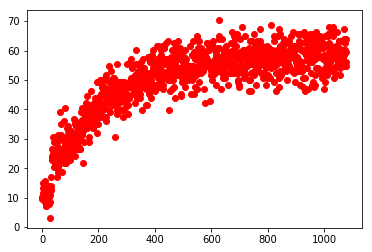

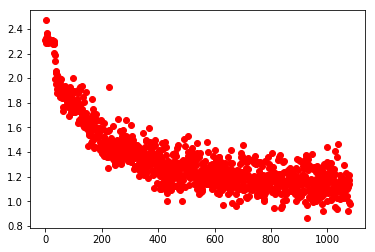

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

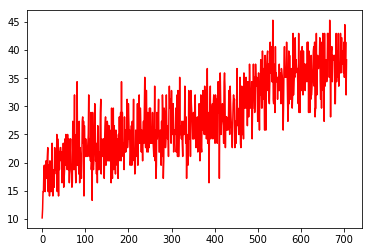

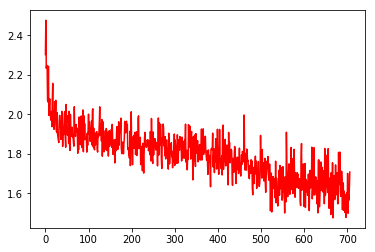

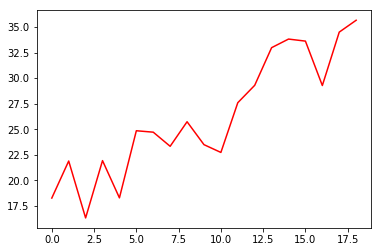

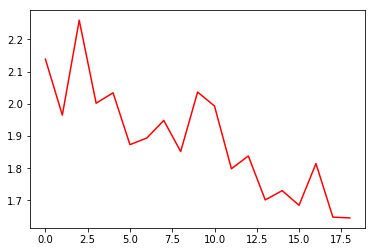

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()